In [1]:
import numpy as np
import pyrallis
import torch
from torch.distributions import Normal, TanhTransform, TransformedDistribution
import torch.nn as nn
import torch.nn.functional as F
import wandb
from typing import Any, Dict, List, Optional, Tuple, Union
from dataclasses import asdict, dataclass
import os
import random
import uuid
import cv2
import copy
from tqdm import tqdm
from torch.utils.data import DataLoader

from dataset import IconDataset

from model.resnet.gan_resnet import Generator, Discriminator, init_net
from train_icon_only_ref import ICAN, TrainConfig, f2uint

import matplotlib.pyplot as plt

In [2]:
config = TrainConfig()
data_path = './data'
device = 'cuda'
model_path = 'ckpt/resnet-color-ref-a1542418/27000.pt'
# themes = ['color', 'fluent', 'doodle', 'clouds', 'plasticine', 'office40', '3d-fluency']

themes = ['color', 'clouds', 'plasticine', 'office40', '3d-fluency']
dataset = IconDataset(data_path, device)

state_dict = torch.load(model_path)
# print(state_dict.keys())
# icAN = ICAN()

generator = Generator(
    num_categories=config.num_categories,
    input_nc=config.input_nc,
    output_nc=config.output_nc,
    ngf=config.ngf,
    norm_layer=config.norm_layer,
    use_dropout=config.use_dropout,
    n_blocks=config.n_blocks,
    padding_type=config.padding_type,
    latent_size=config.latent_size
)
discriminator = Discriminator(
    num_categories=config.num_categories,
    input_nc=config.output_nc,
    ndf=config.ngf,
    n_layers=config.n_layers,
    norm_layer=config.norm_layer   
)

init_net(generator, config.init_type, gpu_id=config.device)
init_net(discriminator, config.init_type, gpu_id=config.device)

generator.load_state_dict(state_dict['encoder'])
discriminator.load_state_dict(state_dict['discriminator'])

icAN = ICAN(generator, discriminator, device)

print(dataset.themes)

loading dataset...: 100%|██████████| 3474/3474 [00:01<00:00, 2095.88it/s]


--------------------------------------------------
#icons: 8625, #themes: 10
initialize network with kaiming
initialize network with kaiming
['color', 'fluent', 'doodle', 'clouds', 'plasticine', 'office40', 'laces', '3d-fluency', 'emoji', '3d-plastilina']


In [3]:
label = 'python'
table = []
for theme in themes:
    if theme in dataset.label2theme[label]:
        icon_src = dataset.read_icon(label, theme)
        icons = [icon_src['img']]
        col = ['src']
        for theme_tar in themes:
            icon_ref = dataset.read_icon_with_rlabel(theme_tar, icon_src)
            # icon_ref = {'img': np.zeros((128, 128, 4))}
            icon_tar = icAN.generate(icon_ref['img'], icon_src['img'], theme_id=dataset.theme2id[theme_tar])
            icons.append(icon_ref['img'])
            icons.append(icon_tar)
            col.append(theme_tar)
            col.append('')
        table.append(icons)

4


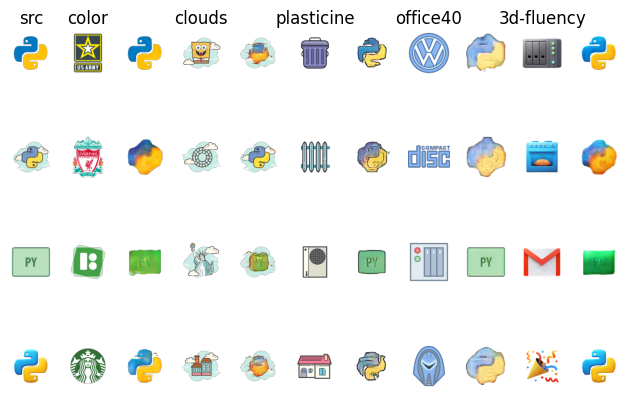

In [4]:
num_rows = len(table)
print(num_rows)
plt.subplots(len(table), len(table[0]) ,sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0, hspace=0)

# 遍历 table，并在子图中显示每个 RGBA 图像
for i in range(num_rows):
    for j in range(len(table[i])):
        rgba_image = cv2.cvtColor(f2uint(table[i][j]), cv2.COLOR_BGRA2RGBA)
        plt.subplot(len(table), len(table[i]), i * len(table[i]) + j + 1)
        plt.imshow(rgba_image, extent=(0, 1, 0, 1))
        plt.axis('off')
        if i == 0:
            ax = plt.subplot(len(table), len(table[i]), i * len(table[i]) + j + 1)
            ax.set_title(col[j])

# 调整子图的布局
plt.tight_layout()

# 显示图形
plt.show()

In [5]:
labels = ['apple-logo', 'zoom', 'youtube', 'windows-11']
table = []
for label in labels:
    icon_src = dataset.read_icon(label, 'color')
    icons = [icon_src['img']]
    col = ['src']
    for theme_tar in themes:
        icon_ref = dataset.read_icon_with_rlabel(theme_tar, icon_src)
        icon_tar = icAN.generate(icon_ref['img'], icon_src['img'], theme_id=dataset.theme2id[theme_tar])
        icons.append(icon_ref['img'])
        icons.append(icon_tar)
        col.append(theme_tar)
        col.append('')
    table.append(icons)

4


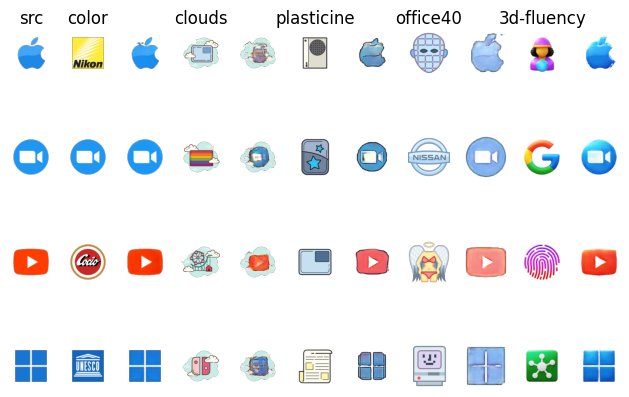

In [6]:
num_rows = len(table)
print(num_rows)
plt.subplots(len(table), len(table[0]) ,sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0, hspace=0)

# 遍历 table，并在子图中显示每个 RGBA 图像
for i in range(num_rows):
    for j in range(len(table[i])):
        rgba_image = cv2.cvtColor(f2uint(table[i][j]), cv2.COLOR_BGRA2RGBA)
        plt.subplot(len(table), len(table[i]), i * len(table[i]) + j + 1)
        plt.imshow(rgba_image, extent=(0, 1, 0, 1))
        plt.axis('off')
        if i == 0:
            ax = plt.subplot(len(table), len(table[i]), i * len(table[i]) + j + 1)
            ax.set_title(col[j])

# 调整子图的布局
plt.tight_layout()

# 显示图形
plt.show()

In [7]:
dataset.theme2id

{'color': 0,
 'fluent': 1,
 'doodle': 2,
 'clouds': 3,
 'plasticine': 4,
 'office40': 5,
 'laces': 6,
 '3d-fluency': 7,
 'emoji': 8,
 '3d-plastilina': 9}

In [8]:
icon = dataset.read_icon('chrome', 'color')
icon_src = icon['img']
icon_ref = np.zeros((128, 128, 4))

theme1 = torch.LongTensor([0]).to(config.device)
theme2 = torch.LongTensor([4]).to(config.device)

icon_ref = torch.FloatTensor(icon_ref).to(config.device).permute(2, 0, 1).unsqueeze(0)
icon_src = torch.FloatTensor(icon_src).to(config.device).permute(2, 0, 1).unsqueeze(0)
icon_src_enc = generator.encoder(torch.cat([icon_src, icon_ref], dim=1))
generator.eval()

table = [[]]
col = []

n = 5

for i in range(n):
    alpha = i / (n - 1)
    print(alpha)
    with torch.no_grad():
        icon = generator.decoder.interpolate(icon_src_enc, theme1, theme2, alpha).squeeze().permute(1, 2, 0).cpu().numpy()
    table[0].append(icon)
    col.append(alpha)

0.0
0.25
0.5
0.75
1.0


1


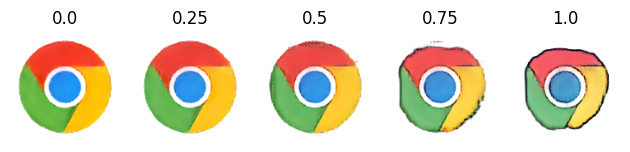

In [9]:
num_rows = len(table)
print(num_rows)
plt.subplots(len(table), len(table[0]) ,sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0, hspace=0)

# 遍历 table，并在子图中显示每个 RGBA 图像
for i in range(num_rows):
    for j in range(len(table[i])):
        rgba_image = cv2.cvtColor(f2uint(table[i][j]), cv2.COLOR_BGRA2RGBA)
        plt.subplot(len(table), len(table[i]), i * len(table[i]) + j + 1)
        plt.imshow(rgba_image, extent=(0, 1, 0, 1))
        plt.axis('off')
        if i == 0:
            ax = plt.subplot(len(table), len(table[i]), i * len(table[i]) + j + 1)
            ax.set_title(col[j])

# 调整子图的布局
plt.tight_layout()

# 显示图形
plt.show()